In [1]:
#import required modules
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

import sys
import os
import numpy as np
import matplotlib.pyplot as plt


import keras
from keras.layers import Lambda,Input,InputLayer, Dense, Activation, Dropout, Flatten, Reshape,ActivityRegularization, TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.losses import binary_crossentropy
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers

In [2]:
!pip install mido
sys.path.insert(1,'../input/pythonscript')
import midi

     |████████████████████████████████| 52 kB 432 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
#load data
#data is preprocessed already on local machine
lengths=np.load('../input/autoencoderdata/lengths.npy')
samples=np.load('../input/autoencoderdata/samples.npy')
min_note,max_note=tuple(np.load('../input/autoencoderdata/min_max_note.npy'))

In [4]:
samples.shape

(13977, 96, 35)

number of sample with 0,1,2,3,4,5 note: [1245156, 96479, 157, 0, 0, 0]


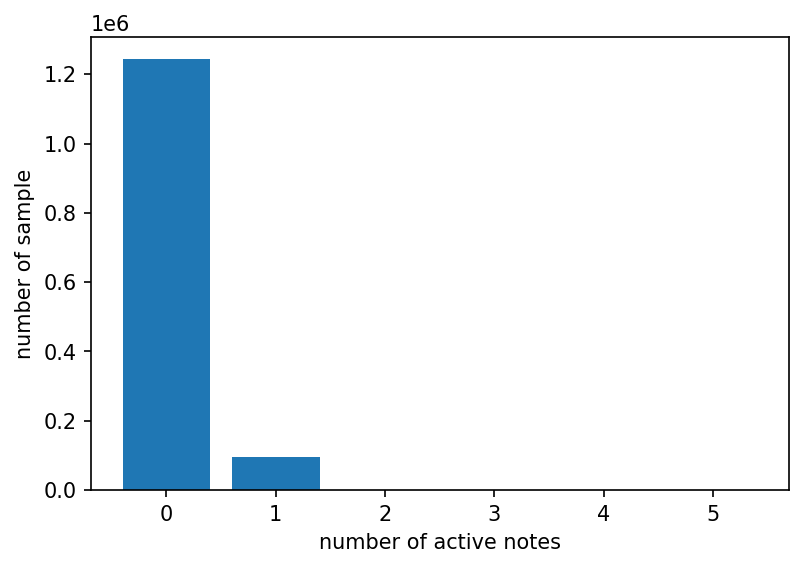

<Figure size 432x288 with 0 Axes>

In [5]:
#create folder for different steps
create_file=['input','training','analysis','output']
for file in create_file:
    try:
        os.mkdir(file)
    except:
        continue
        
        
        
#analyze data samples
a=np.sum(samples,axis=2)
n=[]
for i in range(6):
    n.append(len(np.where(a==i)[0]))
print('number of sample with 0,1,2,3,4,5 note:',n)

plt.figure(dpi=150)
plt.bar(range(6),n)
plt.ylabel('number of sample')
plt.xlabel('number of active notes')
plt.show()
plt.savefig('input/num_sample_vs_num_active_notes.png')

In [6]:
#if trainied model already exists
model_file='../input/autoencoder-data/training/weight.h5'
is_train=True
model_exist=True

In [7]:
#initializations
num_epoch=1000
learning_rate=0.001
is_AE=False
is_VAE=True
dropout_rate=0.1
epsilon_std=1
batch_size=1024
num_measures=16
latent_dim=100


In [8]:
"""
#ready data for a input to a network
network_input=[]
total_length=0

for length in lengths[0:1000]:
    temp=np.concatenate((samples[total_length:total_length+length],samples[total_length:total_length+length]),axis=0)
    if(length==8):
        network_input.append(temp) 
    
    elif(length>8 and length<16):
        for i in range(temp.shape[0]%16):
            network_input.append(temp[i:i+16])     
    
    else:
        for i in range(length):
            network_input.append(temp[i:i+16])
    total_length=total_length+length


network_input=np.concatenate(network_input).reshape(-1,16,96,35)
print("Network_input_shape:",network_input.shape)

#free up some ram memory
del lengths
del samples
"""

'\n#ready data for a input to a network\nnetwork_input=[]\ntotal_length=0\n\nfor length in lengths[0:1000]:\n    temp=np.concatenate((samples[total_length:total_length+length],samples[total_length:total_length+length]),axis=0)\n    if(length==8):\n        network_input.append(temp) \n    \n    elif(length>8 and length<16):\n        for i in range(temp.shape[0]%16):\n            network_input.append(temp[i:i+16])     \n    \n    else:\n        for i in range(length):\n            network_input.append(temp[i:i+16])\n    total_length=total_length+length\n\n\nnetwork_input=np.concatenate(network_input).reshape(-1,16,96,35)\nprint("Network_input_shape:",network_input.shape)\n\n#free up some ram memory\ndel lengths\ndel samples\n'

In [9]:
NUM_OFFSETS=16
MAX_LENGTH=16
print("Loading Data...")
y_samples = samples
y_lengths = lengths
num_samples = y_samples.shape[0]
num_songs = y_lengths.shape[0]
print("Loaded " + str(num_samples) + " samples from " + str(num_songs) + " songs.")
print(np.sum(y_lengths))
assert(np.sum(y_lengths) == num_samples)

print("Padding Songs...")
x_shape = (num_songs * NUM_OFFSETS, 1)
y_shape = (num_songs * NUM_OFFSETS, MAX_LENGTH) + y_samples.shape[1:]
network_input = np.zeros(y_shape, dtype=y_samples.dtype)
cur_ix = 0
for i in range(num_songs):
	for ofs in range(NUM_OFFSETS):
		ix = i*NUM_OFFSETS + ofs
		end_ix = cur_ix + y_lengths[i]
		for j in range(MAX_LENGTH):
			k = (j + ofs) % (end_ix - cur_ix)
			network_input[ix,j] = y_samples[cur_ix + k]
	cur_ix = end_ix
assert(end_ix == num_samples)

test_ix = 0
y_test_song = np.copy(network_input[test_ix:test_ix+1])

midi.samples_to_midi(y_test_song[0], 'gt.mid', 16)
#np.save('y_orig.npy',y_orig)

Loading Data...
Loaded 13977 samples from 490 songs.
13977
Padding Songs...


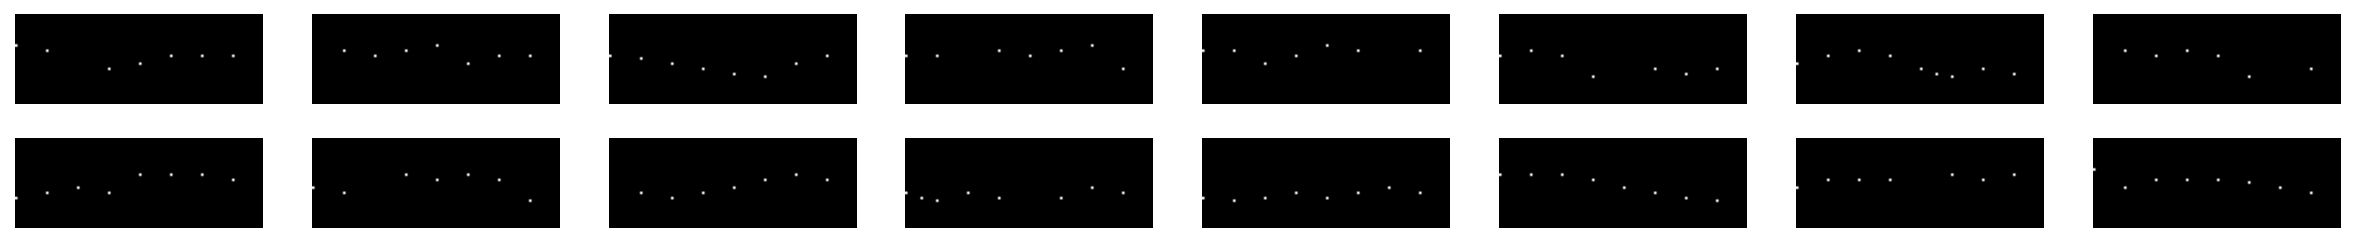

In [10]:
#plot 1st data on network_input
fig,axes=plt.subplots(nrows=2,ncols=8,figsize=(20,2),dpi=150)

for i in range(16):
    axes[i//8,i%8].imshow(network_input[4,i,:,:].T,cmap='gray')
    axes[i//8,i%8].set_axis_off()
fig.savefig('input/midi_piano_roll.png')

In [11]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=K.shape(z_mean),mean=0., stddev=0.005)
    return z_mean + K.exp(z_log_sigma) * epsilon

def loss(x,x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = -  0.5*K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=None)
    vae_loss=xent_loss+kl_loss
    return vae_loss

    

In [12]:
"""
def encoder():
    inputs=Input(shape=network_input.shape[1:])
    x=Reshape((1,network_input.shape[1]*network_input.shape[2]*network_input.shape[3]))(inputs)
    x=Activation('relu')(x)
    z_mean=Dense(latent_dim)(x)
    z_log_sigma=Dense(latent_dim,kernel_initializer='zeros',bias_initializer='zeros')(x)
    z = Lambda(sampling, output_shape=(latent_dim,),name='bottleneck')([z_mean, z_log_sigma])
    return inputs,z,z_mean,z_log_sigma

def decoder():
    latent_inputs=Input(shape=(latent_dim,),name='z_sampling')
    x=Dense(network_input.shape[1]*network_input.shape[2]*network_input.shape[3],name='decoder_1st_layer')(latent_inputs)
    x=Activation('sigmoid')(x)
    outputs=Reshape((network_input.shape[1:]))(x)
    return latent_inputs,outputs
    
"""
BN_M=0.9
DO_RATE=dropout_rate
MAX_LENGTH=16
def encoder():
    inputs=Input(shape=network_input.shape[1:],name='input')
    x=Reshape((network_input.shape[1],96*35),name="Reshape_input")(inputs)
    x=TimeDistributed(Dense(2000, activation='relu'),name='measure_slice')(x)
    x=TimeDistributed(BatchNormalization(momentum=BN_M),name="Batch_norm1")(x)
    x=Dropout(DO_RATE)(x)
    x=TimeDistributed(Dense(200, activation='relu'),name="")(x)
    x=TimeDistributed(BatchNormalization(momentum=BN_M),name="")(x)
    x=Dropout(DO_RATE,name="")(x)
    x=Flatten(name="")(x)
    x=Dense(1600, activation='relu',name="")(x)
    z_mean=Dense(latent_dim,name="mean")(x)
    z_log_sigma=Dense(latent_dim,kernel_initializer='zeros',bias_initializer='zeros',name="log_standard_deviation")(x)
    z = Lambda(sampling, output_shape=(latent_dim,),name='bottleneck_layer')([z_mean, z_log_sigma])
    return inputs,z,z_mean,z_log_sigma
def decoder():
    latent_inputs=Input(shape=(latent_dim,),name='z_sampling')
    x=Dense(1600, activation='relu', name='')(latent_inputs)
    x=BatchNormalization(momentum=BN_M,name="")(x)
    x=Dropout(DO_RATE,name="")(x)
    x=Dense(MAX_LENGTH * 200,activation='relu',name="")(x)
    x=Reshape((MAX_LENGTH, 200),name="")(x)
    x=TimeDistributed(BatchNormalization(momentum=BN_M),name="")(x)
    x=Dropout(DO_RATE,name="")(x)
    x=TimeDistributed(Dense(2000,activation='relu'),name="")(x)  
    x=TimeDistributed(BatchNormalization(momentum=BN_M),name="")(x)
    x=Dropout(DO_RATE,name="")(x)
    x=TimeDistributed(Dense(network_input.shape[2] * network_input.shape[3], activation='sigmoid'),name="")(x)
    outputs=Reshape((network_input.shape[1], network_input.shape[2], network_input.shape[3]),name="")(x)
    return latent_inputs,outputs

In [13]:

inputs,z,z_mean,z_log_sigma=encoder()
latent_inputs,outputs=decoder()
enc=Model(inputs,[z_mean,z_log_sigma,z],name='encoder')
dec=Model(latent_inputs,outputs,name='decoder')
outputs=dec(enc(inputs)[2])
vae=Model(inputs,outputs,name='vae')
plot_model(enc, to_file='training/enc.png', show_shapes=True,show_layer_names=False,dpi=200)
plot_model(dec, to_file='training/dec.png', show_shapes=True,show_layer_names=False,dpi=200)
plot_model(vae, to_file='training/model.png', show_shapes=True,show_layer_names=False,dpi=200)
vae.compile(optimizer=Adam(lr=learning_rate), loss=loss)


In [14]:
if(model_exist):
    vae.load_weights(model_file)

In [15]:
network_input.shape

(7840, 16, 96, 35)

Train on 7448 samples, validate on 392 samples
Epoch 1/200
7424/7448 [============================>.] - ETA: 0s - loss: 0.0089
Epoch 00001: loss improved from inf to 0.00890, saving model to training/weight.h5
7448/7448 [==============================] - 9s 1ms/sample - loss: 0.0089 - val_loss: 0.0081
Epoch 2/200
7448/7448 [==============================] - ETA: 0s - loss: 0.0085
Epoch 00002: loss improved from 0.00890 to 0.00855, saving model to training/weight.h5
7448/7448 [==============================] - 9s 1ms/sample - loss: 0.0085 - val_loss: 0.0084
Epoch 3/200
7448/7448 [==============================] - ETA: 0s - loss: 0.0083
Epoch 00003: loss improved from 0.00855 to 0.00826, saving model to training/weight.h5
7448/7448 [==============================] - 9s 1ms/sample - loss: 0.0083 - val_loss: 0.0095
Epoch 4/200
7448/7448 [==============================] - ETA: 0s - loss: 0.0083
Epoch 00004: loss did not improve from 0.00826
7448/7448 [==============================] - 8s 1m

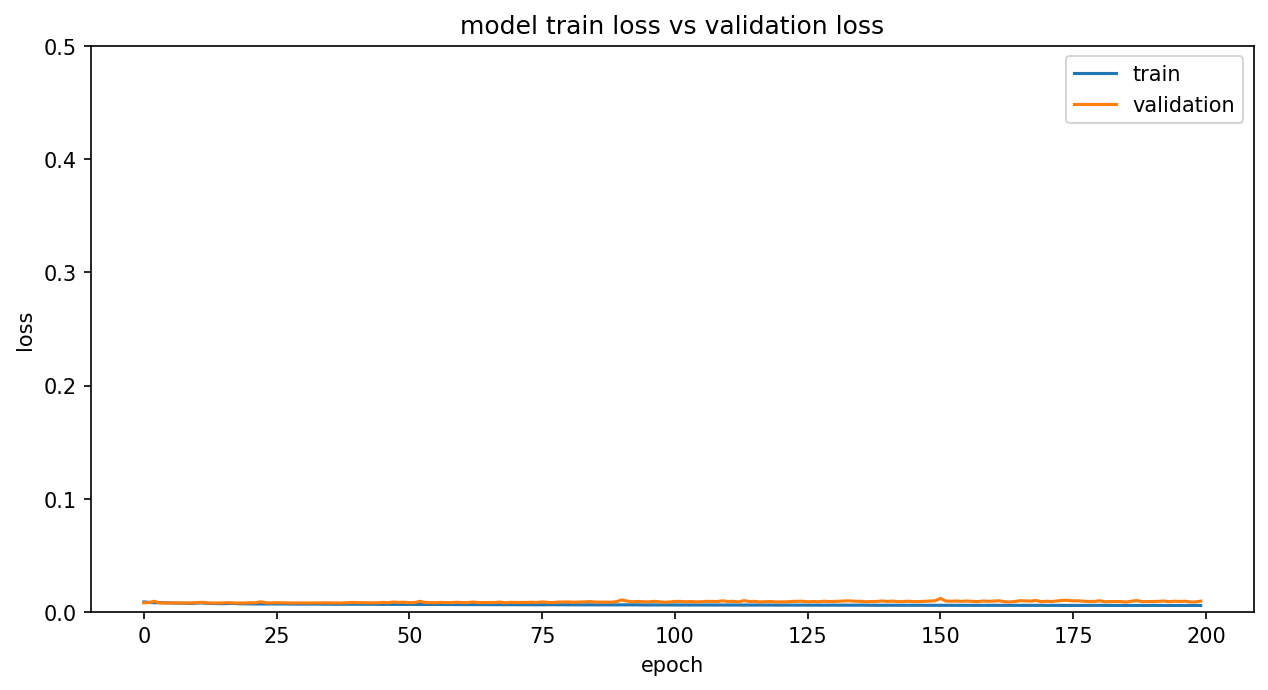

KeyError: 'accuracy'

<Figure size 432x288 with 0 Axes>

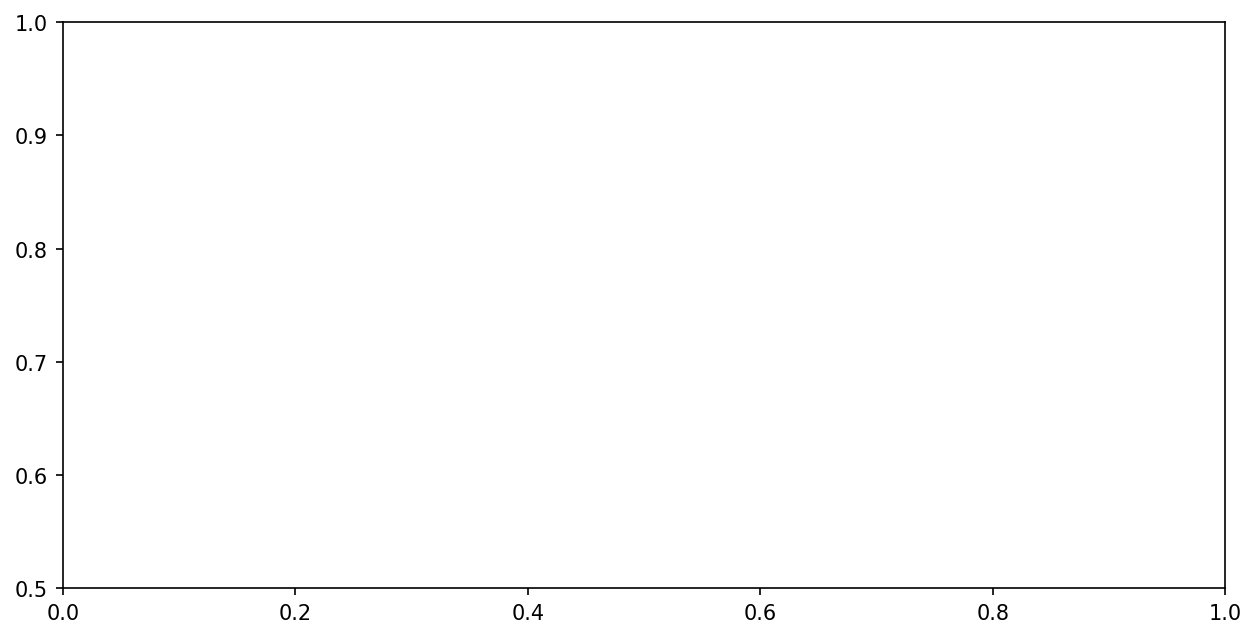

In [16]:

if(is_train):
    
    #callback operation
    filepath='training/weight.h5'
    checkpoint=ModelCheckpoint(filepath,monitor='loss',verbose=1,save_best_only=True)
    #fit the model
    #run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    history=vae.fit(network_input, network_input,batch_size=16,validation_split=0.05,epochs=200, shuffle=True,callbacks=[checkpoint])
    
    #plot loss vs epochs
    plt.figure(figsize=(10,5),dpi=150)
    plt.ylim([0,0.5])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train loss vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    plt.savefig('training/loss.png')
    
    #plot a
    plt.figure(figsize=(10,5),dpi=150)
    plt.ylim([0.5,1])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model train accuracy vs validation accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    plt.savefig('training/accuracy.png')

In [17]:
rand_vecs = np.random.normal(0.0, 1.0, (10, latent_dim))
x_enc = np.squeeze(enc.predict(network_input)[2])
x_mean = np.mean(x_enc, axis=0)
x_stds = np.std(x_enc, axis=0)
x_cov = np.cov((x_enc - x_mean).T)
u, s, v = np.linalg.svd(x_cov)
e = np.sqrt(s)
x_vecs = x_mean + np.dot(rand_vecs * e, v)
np.save('input.npy',x_vecs)

In [18]:

sort_stds=np.sort(x_stds)[::-1]
index_stds=np.zeros((x_stds.shape))


for i in range(sort_stds.shape[0]):
    index_stds[i]=int(np.where(x_stds==sort_stds[i])[0][0])
index_stds=index_stds.astype(np.int32)
np.save('index.npy',index_stds)


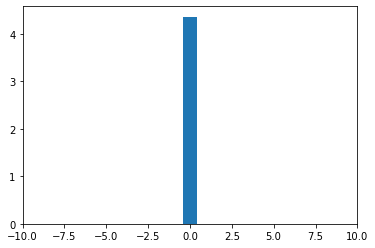

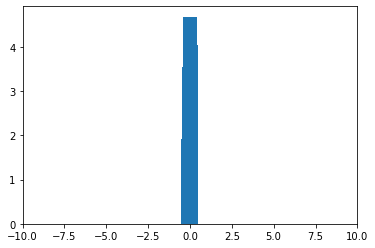

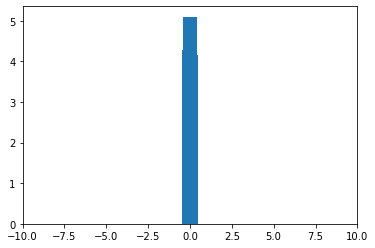

In [19]:
import scipy.stats as stats
proj=x_enc[:,index_stds[0:3]]
means=x_mean[index_stds[0:3]]
stds=sort_stds[0:3]

for i in range(3):
    pdf=stats.norm.pdf(proj[0:500,i],means[i],stds[i])
    plt.xlim(-10,10)
    plt.bar(proj[0:500,i],pdf)
    plt.show()
    

In [20]:
x_enc.shape

(7840, 100)

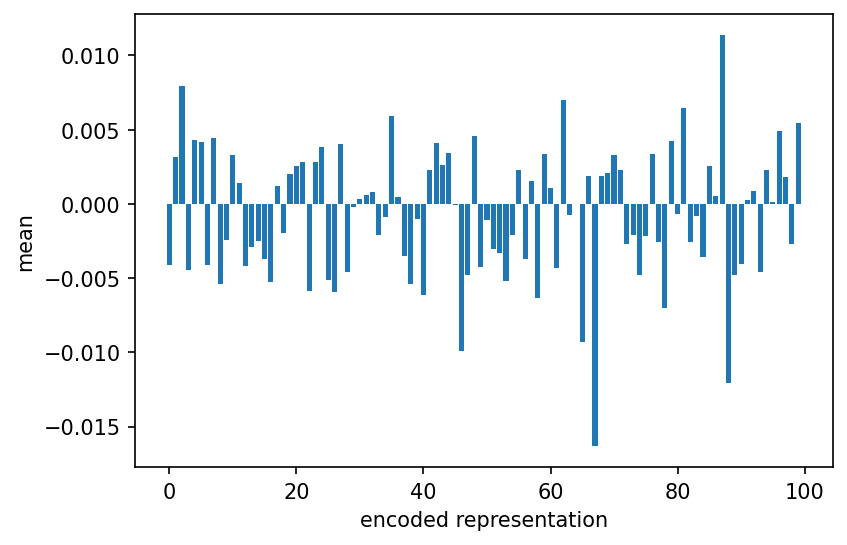

<Figure size 432x288 with 0 Axes>

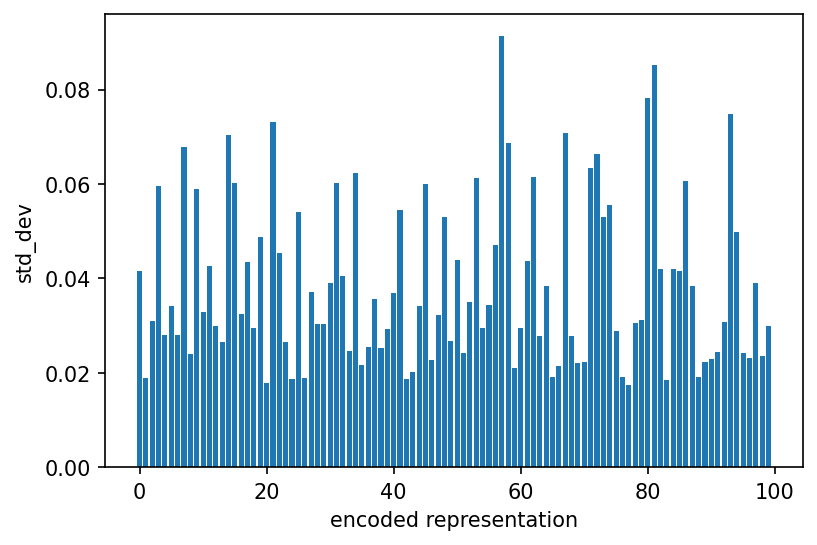

<Figure size 432x288 with 0 Axes>

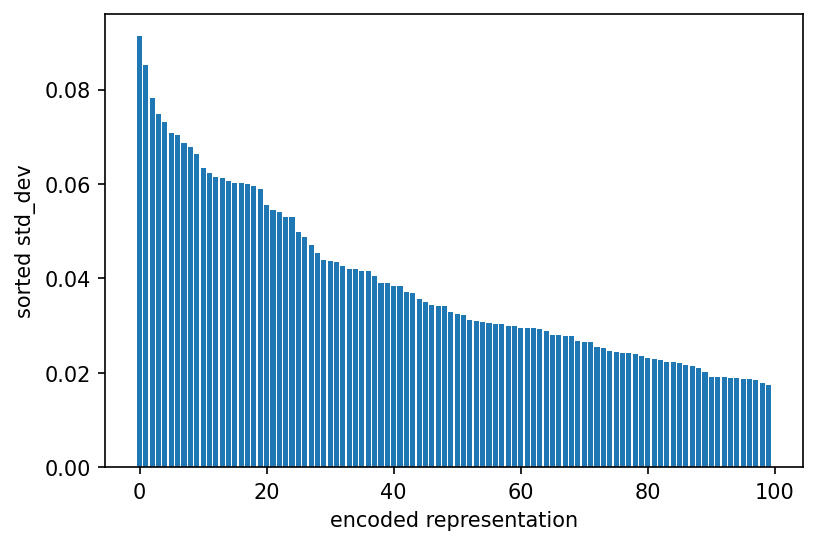

<Figure size 432x288 with 0 Axes>

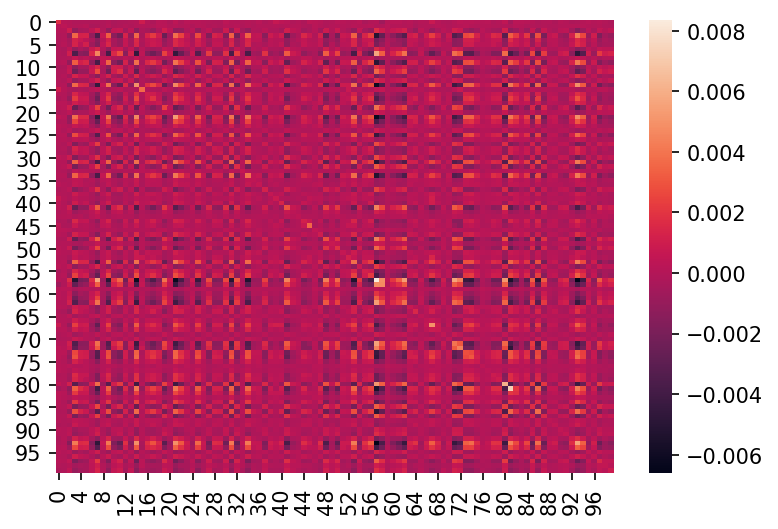

<Figure size 432x288 with 0 Axes>

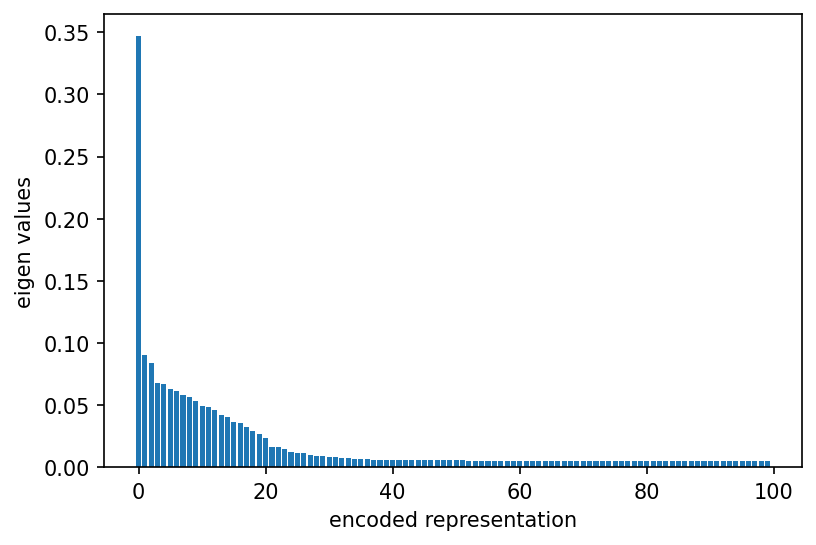

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
#mean graph
plt.figure(dpi=150)
plt.bar(range(latent_dim),x_mean)
plt.ylabel('mean')
plt.xlabel('encoded representation')
plt.show()
plt.savefig('analysis/x_mean.png')

#std_dev graph
plt.figure(dpi=150)
plt.bar(range(latent_dim),(x_stds))
plt.ylabel('std_dev')
plt.xlabel('encoded representation')
plt.show()
plt.savefig('analysis/std_dev.png')

#sorted std_dev graph
plt.figure(dpi=150)
plt.bar(range(latent_dim),(sorted(list(x_stds),reverse=True)))
plt.ylabel('sorted std_dev')
plt.xlabel('encoded representation')
plt.show()
plt.savefig('analysis/sorted_std_dev.png')

#covariance matrix
plt.figure(dpi=150)
sns.heatmap(x_cov[0:latent_dim,0:latent_dim], fmt='g')
plt.show()
plt.savefig('analysis/cov_matrix.png')

#eigen values
plt.figure(dpi=150)
plt.bar(range(latent_dim),e)
plt.ylabel('eigen values')
plt.xlabel('encoded representation')
plt.show()
plt.savefig('analysis/eigen.png')


In [22]:
data=np.zeros((16,96,96))
for i in range(x_vecs.shape[0]):
    song=dec.predict(x_vecs[i:i+1])[0]
    print(song.shape)
    data[:,:,30:65]=song
    midi.samples_to_midi(data,str(i)+'.mid',16,0.15)

(16, 96, 35)
(16, 96, 35)
(16, 96, 35)
(16, 96, 35)
(16, 96, 35)
(16, 96, 35)
(16, 96, 35)
(16, 96, 35)
(16, 96, 35)
(16, 96, 35)


In [23]:
song=enc.predict(network_input[1].reshape(1,16,96,35))[2]
song=dec.predict(song.reshape(1,100))[0]
song.shape

(16, 96, 35)

In [24]:
data=np.zeros((16,96,96))
data[:,:,30:65]=song
midi.samples_to_midi(data,'output.mid',16,0.1)

In [25]:
song.shape

(16, 96, 35)

In [26]:
song=network_input[40]
data[:,:,30:65]=song
midi.samples_to_midi(data,'output.mid',16,0.07)

In [27]:

dec.save_weights('decoder_weights.h5')